James Ho
Olivia Seitelman

Question?
How would the world population be different today if the Green Revolution had never occurred?
How would the growth rate have differed?

Model:
Build a model that fits the population growth before the green revolution (roughly in the 1960's). Extrapolate this model to the present year. This plot can then be compared to the actual population data.

In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_html
import pandas
import numpy as np
from numpy import genfromtxt

In [3]:
# Import the .csv files of the population data
my_data = pandas.read_csv('WorldPopData.csv', sep=',');

In [123]:
# Will modify this function later to plot the model and the data
def plot_results(modelPop, realPop, years, title):
    """Plot the estimates and the model.
    
    modelPop: the predicted population
    realPop: the population from data
    years: the time axis of the plot
    title: string
    """
    plot(years, modelPop, ':' , label='Model')
    plot(years, realPop, label='Data')    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

In [146]:
# Will modify this function later to plot the model
def plot_one_result(realPop, mod1, mod2, mod3, years, title, X_label, Y_Label):
    """Plot the estimates and the model.
    
    realPop: the actual vaules
    mod1, mod2, mod3: the predictions from the three different models used.
    years: the time axis of the plot
    title: string
    X_label: string
    Y_label: string
    Label: string
    """
    plot(years, realPop, label='Real Growth Rate')
    plot(years, mod1, ':', label='Proportional GR')
    plot(years, mod2, ':', label='Quadratic GR')
    plot(years, mod3, ':', label='Polynomial GR')
    decorate(xlabel=X_label, 
             ylabel=Y_Label,
             title=title)

In [147]:
# Cut the data to start from 1900
# Population will be in billions
year1900 = my_data.year.values[11900:12018];
pop1900 = my_data.WorldPop.values[11900:12018]/10**9;

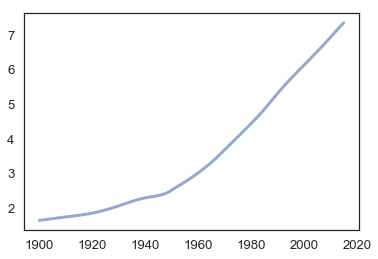

In [148]:
# Test plotting the data
plot(year1900, pop1900)

In [149]:
# Calculate the total average growth rate
t_0 = year1900[0]
t_end = year1900[-1]
elapsed_time = t_end - t_0

p_0 = pop1900[0]
p_end = pop1900[-1]
total_growth = p_end - p_0

annual_growth = total_growth / elapsed_time;

In [150]:
# Create model System object
modelSystem = System(t_0 = t_0,
                    t_end = t_end,
                    p_0 = p_0,
                    annual_growth = annual_growth,
                    birth_rate = 0.02,
                    death_rate = 0.011,
                    alpha = 0.014,
                    beta = -0.003,
                    gamma = -0.00005);

In [151]:
# Define run simulation function
def run_sim(system, update_func):
    """Simulate the system using any update function
    system: System object
    update_func: function that computes the population next year
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], system)
    return results

In [152]:
# Update function: Proportional growth
def update_proportional(pop, system):
    """update function with proportional growth.
    
    system: System object
    pop: the current population
    returns: returns the new population
    """
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    result = births - deaths + pop
    return result

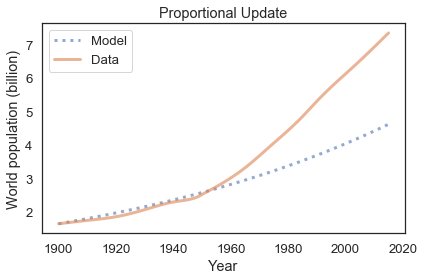

In [153]:
# Run the simulation with the proportional update function.
# Store the results in a variable
# Display plot
population_prop = run_sim(modelSystem, update_proportional);
plot_results(population_prop, pop1900, year1900, "Proportional Update")

In [154]:
# Update function: Quadratic growth
def update_quadratic(pop, system):
    """udpate function with proportional growth.
    
    system: System object
    pop: the current population
    returns: returns the new population
    """
    netGrowth = system.alpha * pop + system.beta * pop**2
    result = netGrowth + pop
    return result

In [206]:
# Model System object
# Best alpha and beta are 0.022, -0.007
modelSystem = System(t_0 = t_0,
                    t_end = t_end,
                    p_0 = p_0,
                    annual_growth = annual_growth,
                    birth_rate = 0.02,
                    death_rate = 0.011,
                    alpha = 0.022,
                    beta = -0.007,
                    gamma = -0.00008);

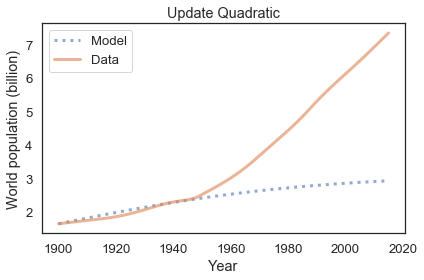

In [207]:
# Run the simulation using the quadtratic update function and plot the results
population_quad = run_sim(modelSystem, update_quadratic);
plot_results(population_quad, pop1900, year1900, "Update Quadratic")

In [208]:
# Update function: polynomial growth
def update_poly(pop, system):
    """udpate function with proportional growth.
    
    system: System object
    pop: the current population
    returns: returns the new population
    """
    netGrowth = system.alpha * pop + system.beta * pop**2 + system.gamma * pop**3
    result = netGrowth + pop
    return result

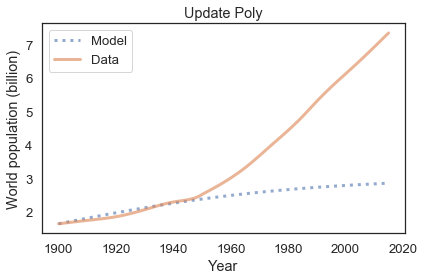

In [209]:
population_poly = run_sim(modelSystem, update_poly);
plot_results(population_poly, pop1900, year1900, "Update Poly")

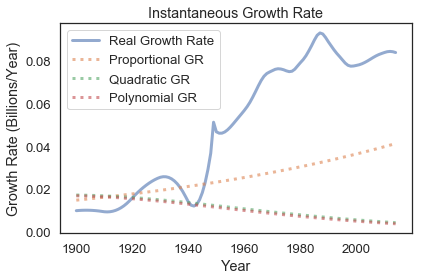

In [236]:
growthRate1900 = np.diff(pop1900);
modelGrowthRate_prop = np.diff(population_prop);
modelGrowthRate_quad = np.diff(population_quad);
modelGrowthRate_poly = np.diff(population_poly);
plot_one_result(growthRate1900, modelGrowthRate_prop, modelGrowthRate_quad, modelGrowthRate_poly, year1900[:-1], "Instantaneous Growth Rate", "Year", "Growth Rate (Billions/Year)")

In [217]:
# Test code for learning gradient descent

In [218]:
def gradient_descent(runs, learning_rate, update_func):
    """Runs the run_sim function and updates the model system parameters
    
    runs: number of iterations of gradient descent
    learning_rate: size of descent steps per iteration
    returns: the final mean squared error  
    prints: the mean squared error for each run
    returns: an array containing the error over iterations
    """
    newWeight = 0;
    newWeight2 = 0;
    newBias = 0;
    error_log = SweepSeries()
    
    for i in range(runs):
        population = run_sim(modelSystem, update_func)
        newParams = update_weights(pop1900, population, newWeight, newWeight2, newBias, learning_rate);
        newWeight = newParams[0];
        newWeight2 = newParams[1];
        newBias = newParams[2];
        modelSystem.alpha = newWeight
        modelSystem.beta = newWeight2
        modelSystem.gamma = newBias
        error = cost_func(pop1900, population);
        print("Iteration: ", i, ", MS Error: ", error);
        error_log[i] = error;
        
    plot_results(population, pop1900, year1900, "Plot After Gradient Descent")
    print("Final error: ", error)
    return error_log

In [219]:
def cost_func(realPop, predictions):
    """calcaulate the mean squared error between the predictions and the actual
    
    realPop: the actual population vector
    predictions: the vector that the simulation generates
    returns: the mean squared error
    """
    n = len(realPop)
    total_error = 0.0
    for i in range(n):
        total_error += (realPop[i] - predictions[i+1900])**2 
    return total_error / n

In [220]:
def update_weights(realPop, predictions, weight, weight2, bias, learning_rate):
    """Update the weights to minimize the error
    
    realPop: actual population
    predictions: the current predicted value of population
    weight: parameter that is being optimized
    bias: another parameter that is being optimized
    learning_rate: the step size of each iteration
    """
    weight_deriv = 0
    weight2_deriv = 0
    bias_deriv = 0
    n = len(realPop)

    for i in range(n):
        # Calculate partial derivatives
        # -2x(y - (mx + b))
        weight_deriv += -2 * (realPop[i] - (predictions[i+1900]))
        
        # Don't know how to find out how each weight contributes to the predictions
        # Another derivative for second weight parameter
        weight2_deriv += -2 * (realPop[i] - (predictions[i+1900]))

        # -2(y - (mx + b))
        bias_deriv += -2*(realPop[i] - (predictions[i+1900]))

    # We subtract because the derivatives point in direction of steepest ascent
    weight -= (weight_deriv / n) * learning_rate
    weight2 -= (weight2_deriv / n) * learning_rate
    bias -= (bias_deriv / n) * learning_rate

    return weight, weight2, bias

In [221]:
# Optimize birthrate with gradient descent
# Model System object
modelSystem_GD = System(t_0 = t_0,
                    t_end = t_end,
                    p_0 = p_0,
                    annual_growth = annual_growth,
                    birth_rate = 0.02,
                    death_rate = 0.011,
                    alpha = 0,
                    beta = 0,
                    gamma = 0,)

,values
t_0,1900.000000
t_end,2015.000000
p_0,1.650000
annual_growth,0.049561
birth_rate,0.020000
death_rate,0.011000
alpha,0.000000
beta,0.000000
gamma,0.000000


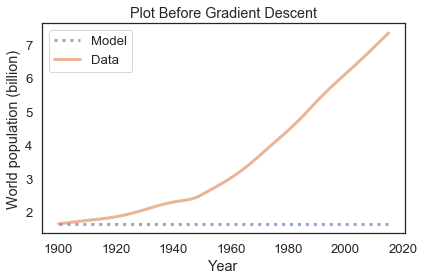

In [229]:
# Start off with bad fit
modelSystem_GD.alpha = 0
modelSystem_GD.beta = 0
population = run_sim(modelSystem_GD, update_quadratic)
plot_results(population, pop1900, year1900, "Plot Before Gradient Descent")

Iteration:  0 , MS Error:  0.0870305427288828
Iteration:  1 , MS Error:  6.764192580735834
Iteration:  2 , MS Error:  6.5364544983955115
Iteration:  3 , MS Error:  6.303628538285574
Iteration:  4 , MS Error:  6.065918269635074
Iteration:  5 , MS Error:  5.823587245825703
Iteration:  6 , MS Error:  5.576966076475984
Iteration:  7 , MS Error:  5.32645957043523
Iteration:  8 , MS Error:  5.072553711648833
Iteration:  9 , MS Error:  4.815822155094698
Iteration:  10 , MS Error:  4.5569318466605715
Iteration:  11 , MS Error:  4.2966472826685465
Iteration:  12 , MS Error:  4.035832838071941
Iteration:  13 , MS Error:  3.77545251664451
Iteration:  14 , MS Error:  3.5165664248183464
Iteration:  15 , MS Error:  3.260323259817218
Iteration:  16 , MS Error:  3.0079481517535793
Iteration:  17 , MS Error:  2.760725328720639
Iteration:  18 , MS Error:  2.519975301649855
Iteration:  19 , MS Error:  2.2870266029483015
Iteration:  20 , MS Error:  2.063182558133802
Iteration:  21 , MS Error:  1.849684102

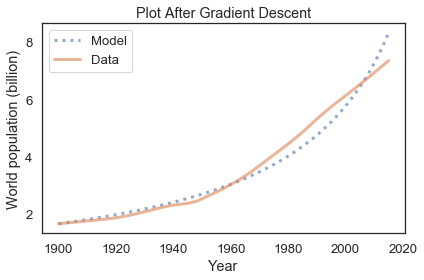

In [235]:
# Run gradient descent and log the progress over iterations
error_log = gradient_descent(50, 0.00004, update_quadratic);